In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import pandas as pd
from pathlib import Path
import cv2
from tensorflow.keras.models import Model

In [2]:
from tensorflow.keras.models import load_model

model = load_model("results/model_weights/final_model.h5", compile=False)

## Configuration

In [3]:
import pandas as pd

label_csv = "../data/cibs-ddsm/metadata/labels_resolved.csv"
labels_df = pd.read_csv(label_csv)

# Select 2 benign and 2 malignant samples
benign_samples = labels_df[labels_df["label"] == 0].sample(2, random_state=42)
malignant_samples = labels_df[labels_df["label"] == 1].sample(2, random_state=42)

# Combine into one sample dataframe
sample_df = pd.concat([benign_samples, malignant_samples]).reset_index(drop=True)

IMG_SIZE = (224, 224)

## Loading of model

In [4]:
from tensorflow.keras.models import load_model

model_path = "../results/model_weights/final_model.h5"
model = load_model(model_path, compile=False)
last_conv_layer_name = "conv2d_5"

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,906,945 (91.20 MB)

 Trainable params: 23,906,945 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

## Choosing image for preprocessing

In [6]:
# --- Preprocessing function ---
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # (1, 224, 224, 1)
    return img


## Pick test samples (malignant and benign)

In [7]:
labels_df = pd.read_csv(label_csv)

benign_samples = labels_df[labels_df["label"] == 0].sample(2, random_state=42)
malignant_samples = labels_df[labels_df["label"] == 1].sample(2, random_state=42)

sample_df = pd.concat([benign_samples, malignant_samples]).reset_index(drop=True)

## Grad-CAM function

_ = model(tf.convert_to_tensor(img_array))  # Initialize model## Overlay heatmap on image

In [8]:
# === RUN Grad-CAM on 5 Sample Malignant Images ===
sample_df = labels_df[labels_df["label"] == 1].sample(5, random_state=42)

In [9]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom

# Functional API
input_layer = Input(shape=(224, 224, 1))
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = Conv2D(32, (3, 3), activation="relu")(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation="relu", name="last_conv")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# If you trained the model earlier and saved weights only:
# model.load_weights("results/model_weights/final_model_weights.h5")

In [11]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # (H, W)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # (1, 224, 224, 1)
    return img

In [12]:
# Drill into the nested model if needed
inner_model = model
while isinstance(inner_model.layers[-1], tf.keras.Model):
    inner_model = inner_model.layers[-1]

for layer in inner_model.layers:
    print(layer.name)

input_layer
random_flip
random_rotation
random_zoom
conv2d
max_pooling2d
last_conv
max_pooling2d_1
flatten
dense
dropout
dense_1


In [13]:
def make_gradcam_heatmap_direct(img_array, model, last_conv_layer_name):
    # Traverse into nested model if needed
    inner_model = model
    while isinstance(inner_model.layers[-1], tf.keras.Model):
        inner_model = inner_model.layers[-1]

    last_conv_layer = inner_model.get_layer(last_conv_layer_name)

    # Build grad model
    grad_model = tf.keras.Model(
        inputs=inner_model.input,
        outputs=[last_conv_layer.output, inner_model.output]
    )

    # ✅ Disable data augmentation by setting training=False
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap

In [14]:
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    original_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Resize and normalize
    heatmap_resized = cv2.resize(heatmap.numpy(), IMG_SIZE)
    heatmap_resized = np.maximum(heatmap_resized, 0)
    heatmap_resized /= np.max(heatmap_resized) + 1e-8

    # 🔥 Boost highlight
    low_clip = 0.4
    heatmap_resized = np.clip(heatmap_resized, low_clip, 1.0)
    heatmap_resized = (heatmap_resized - low_clip) / (1.0 - low_clip)

    # Apply colormap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    # Stretch heatmap using 95th percentile
    vmin = np.percentile(heatmap_resized, 60)
    vmax = np.percentile(heatmap_resized, 99)
    heatmap_rescaled = np.clip((heatmap_resized - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # Overlay
    overlay = cv2.addWeighted(original_rgb, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

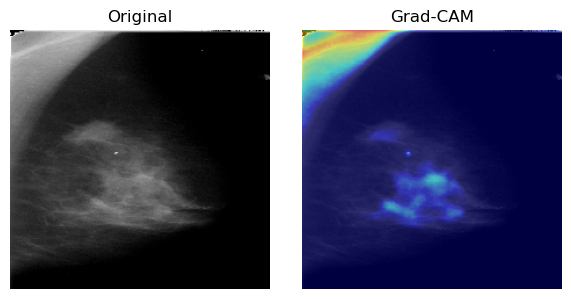

In [15]:
img_path = sample_df.iloc[0]["image_file_path"]

# 1. Warm-up the model (to ensure outputs exist)
_ = model(tf.convert_to_tensor(preprocess_image(img_path), dtype=tf.float32))

# 2. Run Grad-CAM
img_array = preprocess_image(img_path)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

heatmap = make_gradcam_heatmap_direct(img_tensor, model, last_conv_layer_name="last_conv")
overlay = overlay_heatmap(img_path, heatmap)

# 3. Plot
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
original_img = cv2.resize(original_img, IMG_SIZE)
plt.imshow(original_img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM")
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
prediction = model(img_tensor)
print("Model output:", prediction.numpy())

Model output: [[0.5133285]]


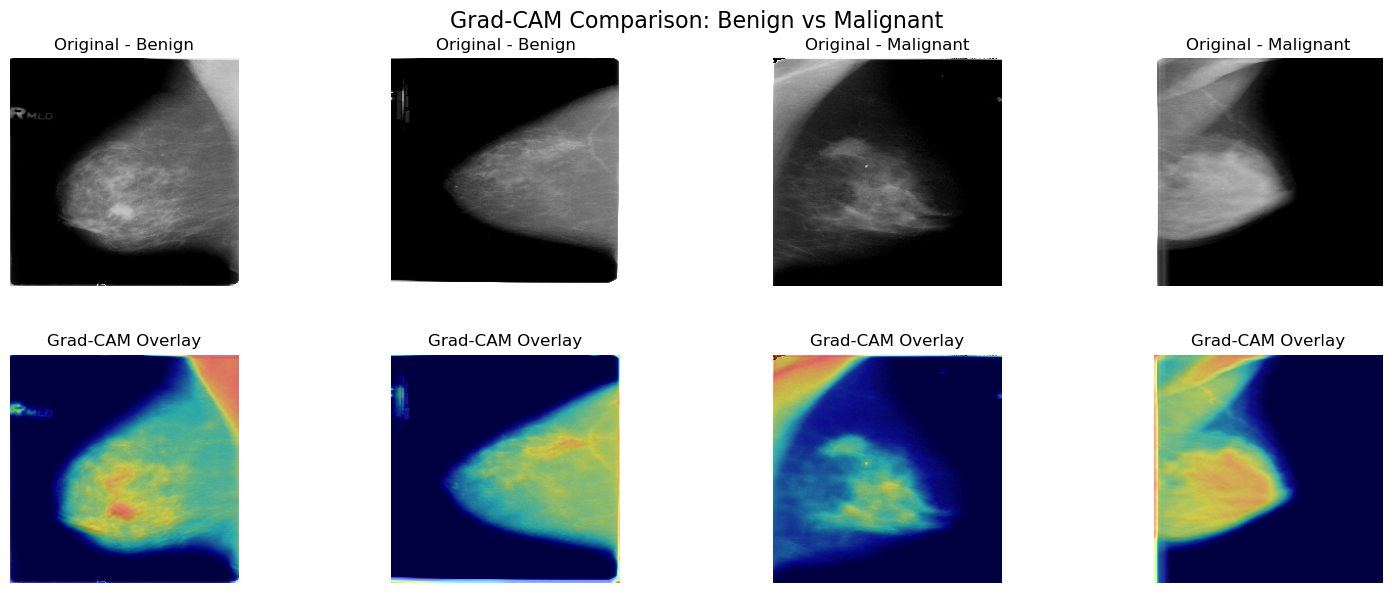

In [17]:
import matplotlib.pyplot as plt

# Select 2 benign and 2 malignant samples
benign_samples = labels_df[labels_df["label"] == 0].sample(2, random_state=42)
malignant_samples = labels_df[labels_df["label"] == 1].sample(2, random_state=42)
sample_df = pd.concat([benign_samples, malignant_samples]).reset_index(drop=True)

# Setup plot
n_cols = len(sample_df)
fig, axes = plt.subplots(2, n_cols, figsize=(4 * n_cols, 6))
fig.suptitle("Grad-CAM Comparison: Benign vs Malignant", fontsize=16)

for i, row in sample_df.iterrows():
    img_path = row["image_file_path"]
    label = "Malignant" if row["label"] == 1 else "Benign"

    # Preprocess
    img_array = preprocess_image(img_path)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Warm-up model (ensures outputs exist, disables random augmentations)
    _ = model(img_tensor, training=False)

    # Grad-CAM
    heatmap = make_gradcam_heatmap_direct(img_tensor, model, last_conv_layer_name="last_conv")
    heatmap_np = heatmap.numpy()

    # Load and prepare original image
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_img = cv2.resize(original_img, IMG_SIZE)
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

    # Heatmap overlay
    heatmap_resized = cv2.resize(heatmap_np, IMG_SIZE)
    heatmap_resized = np.maximum(heatmap_resized, 0)
    heatmap_resized /= np.max(heatmap_resized) + 1e-8
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(original_rgb, 0.5, heatmap_color, 0.5, 0)

    # Plot original
    axes[0, i].imshow(original_img, cmap="gray")
    axes[0, i].set_title(f"Original - {label}", fontsize=12)
    axes[0, i].axis("off")

    # Plot Grad-CAM
    axes[1, i].imshow(overlay)
    axes[1, i].set_title("Grad-CAM Overlay", fontsize=12)
    axes[1, i].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.3)
plt.show()